In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
import pathlib

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import display

In [2]:
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

In [3]:
# patch tf1 into `utils.ops`
utils_ops.tf = tf.compat.v1

# Patch the location of gfile
tf.gfile = tf.io.gfile

In [4]:
def load_model(model_name):
  base_url = 'http://download.tensorflow.org/models/object_detection/'
  model_file = model_name + '.tar.gz'
  model_dir = tf.keras.utils.get_file(
    fname=model_name, 
    origin=base_url + model_file,
    untar=True)

  model_dir = pathlib.Path(model_dir)/"saved_model"

  model = tf.saved_model.load(str(model_dir))
  model = model.signatures['serving_default']

  return model

In [5]:
PATH_TO_LABELS = 'object_detection/data/mscoco_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

In [6]:
PATH_TO_TEST_IMAGES_DIR = pathlib.Path('object_detection/test_images')
TEST_IMAGE_PATHS = sorted(list(PATH_TO_TEST_IMAGES_DIR.glob("*.jpg")))
TEST_IMAGE_PATHS

[WindowsPath('object_detection/test_images/image1.jpg'),
 WindowsPath('object_detection/test_images/image2.jpg'),
 WindowsPath('object_detection/test_images/image3.jpg')]

In [7]:
model_name = 'ssd_mobilenet_v1_coco_2017_11_17'
detection_model = load_model(model_name)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [8]:
print(detection_model.inputs)

[<tf.Tensor 'image_tensor:0' shape=(None, None, None, 3) dtype=uint8>]


In [9]:
detection_model.output_dtypes

{'num_detections': tf.float32,
 'detection_boxes': tf.float32,
 'detection_classes': tf.float32,
 'detection_scores': tf.float32}

In [10]:
detection_model.output_shapes

{'num_detections': TensorShape([None]),
 'detection_boxes': TensorShape([None, 100, 4]),
 'detection_classes': TensorShape([None, 100]),
 'detection_scores': TensorShape([None, 100])}

In [11]:
def run_inference_for_single_image(model, image):
  image = np.asarray(image)
  input_tensor = tf.convert_to_tensor(image)
  input_tensor = input_tensor[tf.newaxis,...]

  output_dict = model(input_tensor)
    
  num_detections = int(output_dict.pop('num_detections'))
  output_dict = {key:value[0, :num_detections].numpy() 
                 for key,value in output_dict.items()}
  output_dict['num_detections'] = num_detections

  output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
   
  if 'detection_masks' in output_dict:
    detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
              output_dict['detection_masks'], output_dict['detection_boxes'],
               image.shape[0], image.shape[1])      
    detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                       tf.uint8)
    output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()
    
  return output_dict

In [12]:
def show_inference(model, image_path):

  image_np = image_path
  image_np = cv2.cvtColor(image_np,cv2.COLOR_BGR2RGB)
  output_dict = run_inference_for_single_image(model, image_np)
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks_reframed', None),
      use_normalized_coordinates=True,
      line_thickness=8)

  display(Image.fromarray(image_np))

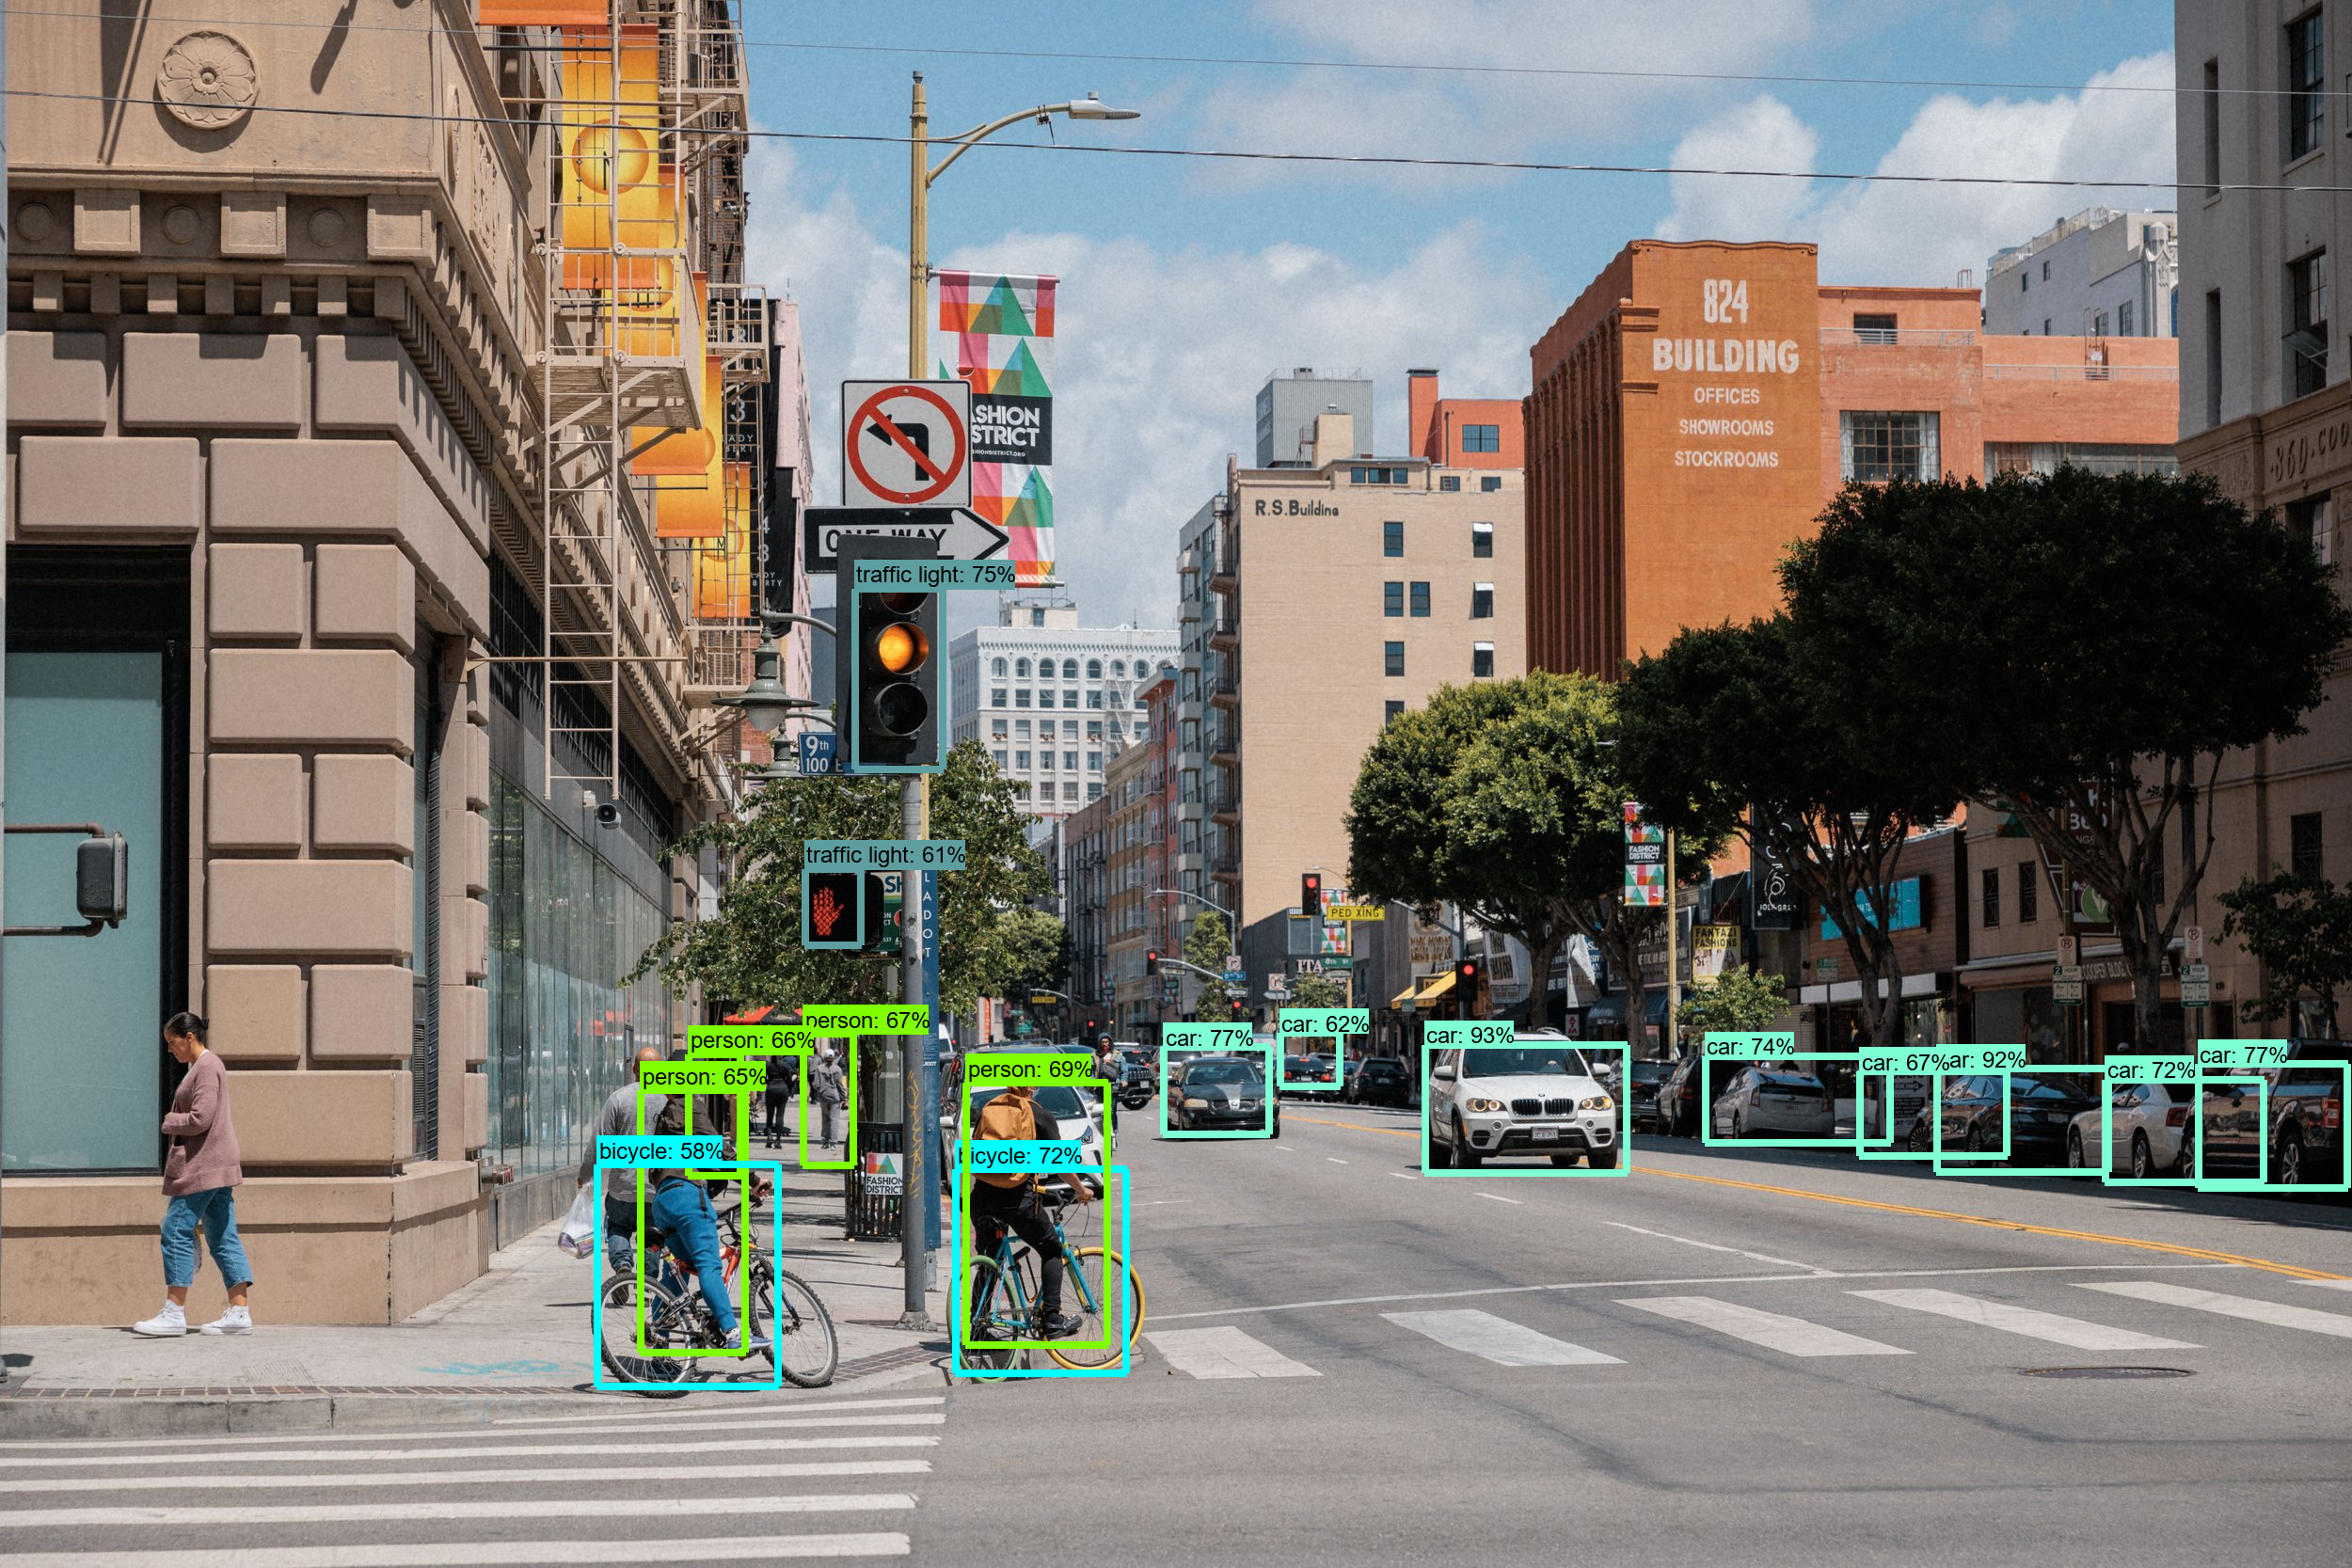

In [13]:
import cv2

img =cv2.imread(r'C:\Users\oshad\Downloads\img1.jpg')
show_inference(detection_model, img)

In [14]:
def show_inference(model, image_path):

  image_np = image_path
  image_np = cv2.cvtColor(image_np,cv2.COLOR_BGR2RGB)
  output_dict = run_inference_for_single_image(model, image_np)
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks_reframed', None),
      use_normalized_coordinates=True,
      line_thickness=8)

  image_np = cv2.cvtColor(image_np,cv2.COLOR_BGR2RGB)
  return image_np

In [15]:
import tensorflow as tf
import pathlib

def load_model(model_name):
    base_url = 'http://download.tensorflow.org/models/object_detection/'
    model_file = model_name + '.tar.gz'
    model_dir = tf.keras.utils.get_file(
        fname=model_name, 
        origin=base_url + model_file,
        untar=True
    )

    model_dir = pathlib.Path(model_dir) / "saved_model"

    model = tf.saved_model.load(str(model_dir))
    model = model.signatures['serving_default']

    return model

In [16]:
detection_model = load_model('ssd_mobilenet_v1_coco_2017_11_17')

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [17]:
import cv2

video = cv2.VideoCapture(r'C:\Users\oshad\Downloads\vid1.mp4')

running = True

try:
    while running:
        ret, img = video.read()
        img = show_inference(detection_model, img)
        k = cv2.waitKey(1)
        cv2.imshow('LIVE', img)

        if k == 27: 
            running = False
except KeyboardInterrupt:
    print("Execution interrupted by user.")
finally:
    video.release()
    cv2.destroyAllWindows()
    print("Resources released and windows closed.")

Resources released and windows closed.
